In [1]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging

sys.path.append("../../")
import manifold_flow as mf
from manifold_flow import transforms, utils, flows, distributions, training
from manifold_flow import nn as nn_
from experiments.data_generation.spherical_simulator import simulator, true_logp, _transform_x_to_z, _transform_z_to_x

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Data

In [2]:
latent_dim = 1
data_dim = 2
n = 10000
epsilon = 0.01

phases = 1.25*np.pi*np.ones(latent_dim)
widths = 0.5*np.ones(latent_dim)

x = simulator(epsilon, latent_dim, data_dim, n, phases, widths)

../../experiments/data_generation/spherical_simulator.py:82: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=epsilon).pdf(z_eps))


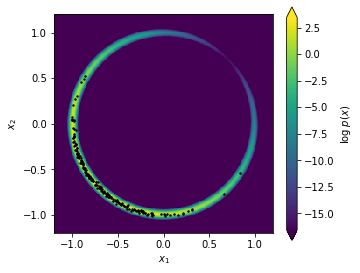

In [3]:
res = 250
x_range = np.linspace(-1.2,1.2,res)
y_range = np.linspace(-1.2,1.2,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = true_logp(x_grid, epsilon, latent_dim, phases, widths).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.

zmin, zmax = np.max(logp_grid) - 20, np.max(logp_grid)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.2,1.2,-1.2,1.2),
    origin="lower",
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x[::50,0], x[::50,1], s=2., c="black", alpha=1.)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_data.pdf", dpi=500)

## Train manifold flow

In [4]:
outer_trf = flows.vector_transforms.create_transform(
    dim=2,
    flow_steps=3,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    hidden_features=10,
    num_transform_blocks=2,
    dropout_probability=0.,
    use_batch_norm=False
)

inner_trf = transforms.ElementwisePiecewiseRationalQuadraticTransform()

flow = flows.manifold_flow.ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_trf,
    outer_transform=outer_trf,
)

14:32 manifold_flow.flows.manifold_f DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
14:32 manifold_flow.flows.manifold_f DEBUG   Created manifold flow with 0.0 M parameters (0.0 M trainable) with an estimated size of 0.0 GB


In [5]:
x_tensor = torch.from_numpy(x)
dataset = TensorDataset(x_tensor, x_tensor)

trainer = training.trainer.AutoencodingFlowTrainer(flow)
trainer.train(
    dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[1., 0.],
    epochs=10,
)

14:32 manifold_flow.training.trainer INFO    Training on CPU with single precision
14:32 manifold_flow.training.trainer DEBUG   Initialising training data
14:32 manifold_flow.training.trainer DEBUG   Setting up optimizer
14:32 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
14:32 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
14:32 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
14:32 manifold_flow.training.trainer DEBUG   Beginning main training loop
14:32 manifold_flow.training.trainer DEBUG   Training epoch 1 / 10
14:32 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]


AssertionError: 

In [7]:
trainer.train(
    dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[1., 0.01],
    epochs=10,
)

14:23 manifold_flow.training.trainer DEBUG   Initialising training data
14:23 manifold_flow.training.trainer DEBUG   Setting up optimizer
14:23 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
14:23 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
14:23 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
14:23 manifold_flow.training.trainer DEBUG   Beginning main training loop
14:23 manifold_flow.training.trainer DEBUG   Training epoch 1 / 10
14:23 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
14:24 manifold_flow.training.trainer INFO    Epoch   1: train loss -0.04929 (mse:  0.000, nll: -4.974)
14:24 manifold_flow.training.trainer INFO               val. loss  -0.05988 (mse:  0.001, nll: -6.042)
14:24 manifold_flow.training.trainer DEBUG   Training epoch 2 / 10
14:24 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
14:24 manifold_flow.training.trainer INFO    Epoch   2: train

(array([-0.0492904 , -0.05247794, -0.04797004, -0.05904539, -0.04766263,
        -0.04858996, -0.06207906, -0.06147732, -0.05312977, -0.05584895]),
 array([-0.05987591, -0.04639643, -0.06220285, -0.0535999 , -0.04548093,
        -0.05267219, -0.06004887, -0.0519239 , -0.05329616, -0.05651681]))

## Manifold flow performance

### Generation

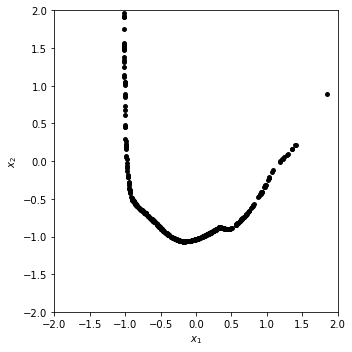

In [8]:
x_gen = flow.sample(n=1000)

# res = 101
# x_range = np.linspace(-1.2,1.2,res)
# y_range = np.linspace(-1.2,1.2,res)
# xx, yy = np.meshgrid(x_range, y_range)
# x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
# logp_grid = true_logp(x_grid, epsilon, latent_dim, phases, widths).reshape((res, res))
# logp_grid[~np.isfinite(logp_grid)] = -1000000.

# zmin, zmax = -100., 10.
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

# pcm = plt.pcolormesh(
#     x_range, y_range,
#     np.clip(logp_grid, zmin, zmax),
#     cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
# )
# cb = plt.colorbar(pcm, extend="both")
plt.scatter(x_gen.detach().numpy()[:,0], x_gen.detach().numpy()[:,1], s=15., c="black")

plt.xlim(-2.0,2.0)
plt.ylim(-2.0,2.0)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_generation.pdf")

### Reconstruction

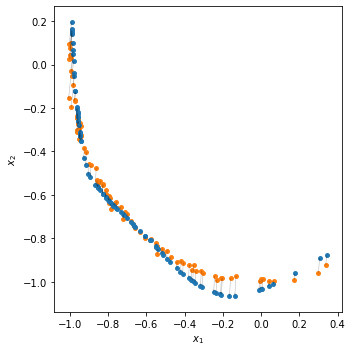

In [10]:
x_in = simulator(epsilon, latent_dim, data_dim, 100, phases, widths)
x_in = torch.FloatTensor(x_in)
x_out = flow(x_in)[0]
x_in, x_out = x_in.detach().numpy(), x_out.detach().numpy()
dx = x_out - x_in

fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plt.scatter(x_in[:,0], x_in[:,1], s=15., c="C1")
plt.scatter(x_out[:,0], x_out[:,1], s=15., c="C0")
plt.quiver(
    x_in[:,0], x_in[:,1], dx[:,0], dx[:,1],
    angles='xy', scale_units='xy', scale=1., width=2.e-3, alpha=0.25
)

# plt.xlim(-1.2,1.2)
# plt.ylim(-1.2,1.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_reconstruction.pdf")


### Log likelihood

In [11]:
res = 51
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)
logp_grid = flow.log_prob(x_grid_tensor)


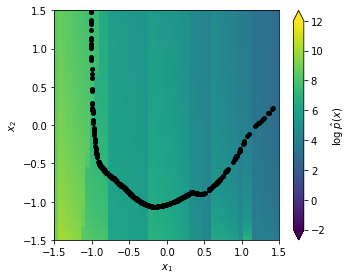

In [12]:
zmin, zmax = -2., 12.
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.pcolormesh(
    x_range, y_range,
    np.clip(logp_grid.detach().numpy().reshape(res, res), zmin, zmax),
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
)
cb = plt.colorbar(pcm, extend="both")
#plt.scatter(x[::100,0], x[::100,1], s=15., c="black")
plt.scatter(x_gen.detach().numpy()[:,0], x_gen.detach().numpy()[:,1], s=15., c="black")

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; \hat{p}(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_log_prob.pdf")

## Latent variables

In [13]:
res = 51
x_range = np.linspace(-100.,100.,res)
y_range = np.linspace(-100.,100.,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

_, _, u = flow(x_grid_tensor)


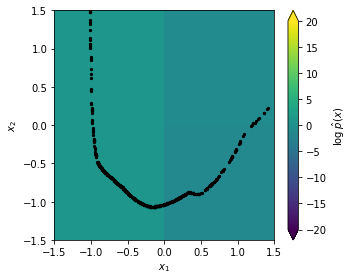

In [15]:
zmin, zmax = -20., 20.
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.pcolormesh(
    x_range, y_range,
    np.clip(u.detach().numpy().reshape(res, res), zmin, zmax),
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
)
cb = plt.colorbar(pcm, extend="both")
#plt.scatter(x[::100,0], x[::100,1], s=15., c="black")
plt.scatter(x_gen.detach().numpy()[:,0], x_gen.detach().numpy()[:,1], s=5., c="black")

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; \hat{p}(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_latent.pdf")